# Face Mask Detection With Transfer Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from skimage.transform import resize
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers, applications
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [18]:
with_mask = glob('with_mask/with_mask/*.jpg')
without_mask = glob('without_mask/without_mask/*.jpg')

In [19]:
image = []
label = []

for i in with_mask:
    img = plt.imread(i)
    image.append(img)
    label.append(0)
    
for i in without_mask:
    img = plt.imread(i)
    image.append(img)
    label.append(1)

In [20]:
label_dict = {0:'with_mask', 1:'without_mask'}

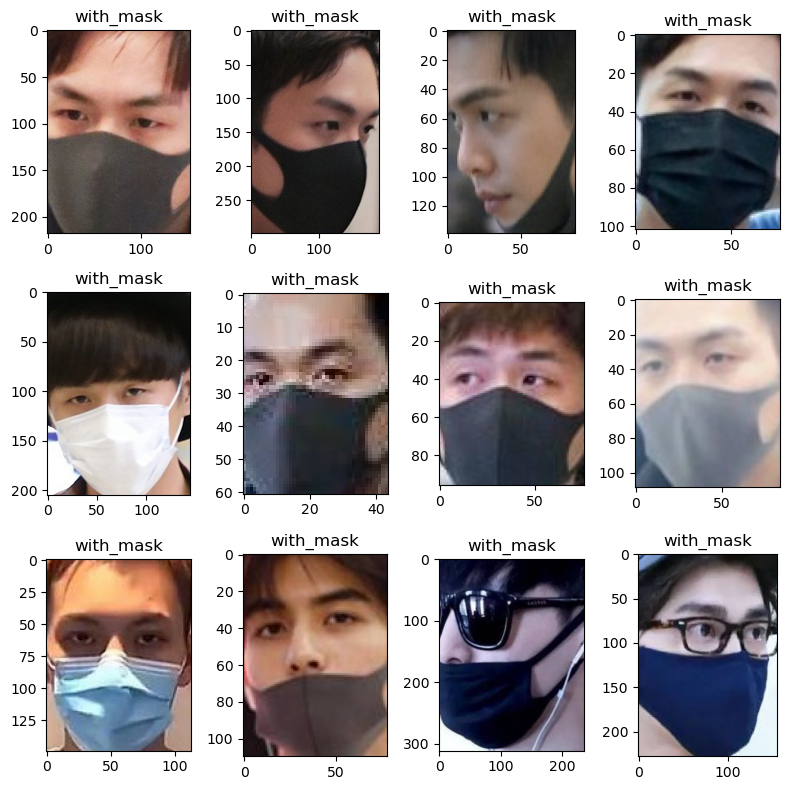

In [21]:
plt.figure(figsize = (8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image[i])
    plt.title(label_dict[label[i]])
plt.tight_layout()

In [22]:
image,label = shuffle(image,label)

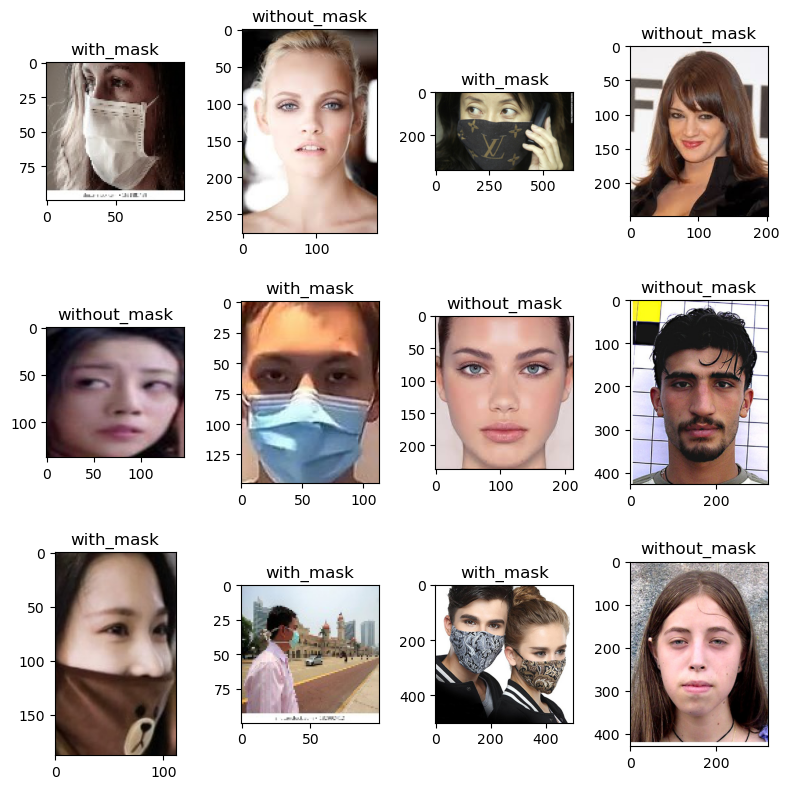

In [23]:
plt.figure(figsize = (8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image[i])
    plt.title(label_dict[label[i]])
plt.tight_layout()

### Resize Images to MobileNetV2 Input Shape (224,224,3)

In [24]:
X = []

for i in image:
    X.append(resize(i, (224,224,3)))

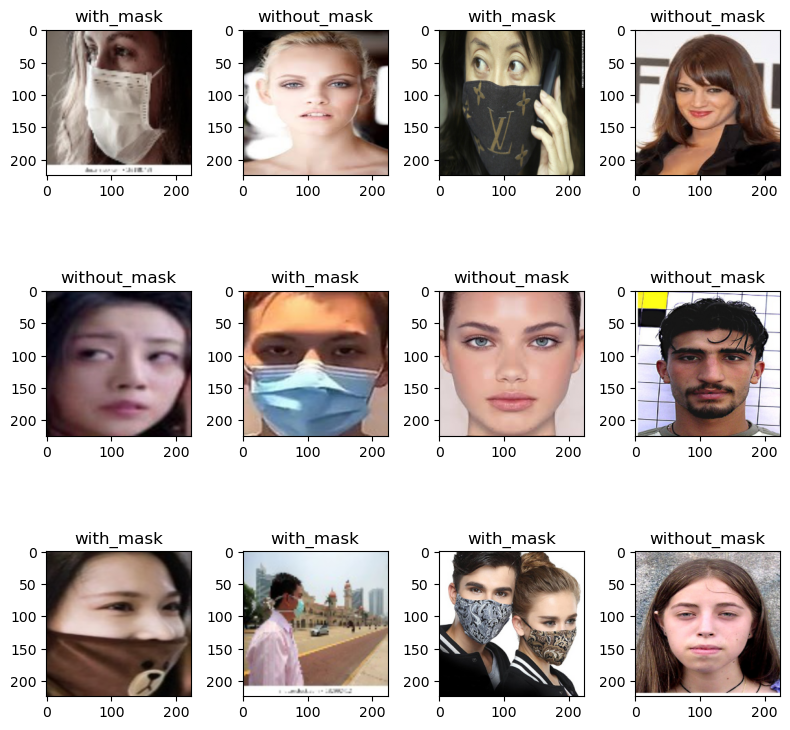

In [25]:
plt.figure(figsize = (8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i])
    plt.title(label_dict[label[i]])
plt.tight_layout()

In [26]:
X = np.array(X)
y = np.array(label)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### MobileNetV2 Pre-trained Feature Extractor Model URL

In [28]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

### Load Pre-trained MobileNetV2 Feature Extractor Model

In [29]:
hub.load(feature_extractor_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x206df9c0310>

### Instantiate MobileNetV2 without Top Layer as Feature Extractor

In [30]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape = (224,224,3), trainable = False
)

### Build Transfer Learning Model using MobileNetV2 Feature Extractor

In [31]:
model = Sequential([
    pretrained_model_without_top_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.1),
    
    layers.Dense(14, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

In [32]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [33]:
model.fit(X_train,y_train, epochs = 5, validation_split = 0.05)

Epoch 1/5
31/31 [==============================] - 41s 1s/step - loss: 0.1621 - accuracy: 0.9300 - val_loss: 0.0277 - val_accuracy: 0.9808
Epoch 2/5
31/31 [==============================] - 33s 1s/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 3/5
31/31 [==============================] - 33s 1s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/5
31/31 [==============================] - 33s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/5
31/31 [==============================] - 37s 1s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0100 - val_accuracy: 1.0000


In [34]:
y_pred = model.predict(X_test)

8/8 [==============================] - 10s 1s/step


In [35]:
y_pred = [np.argmax(i) for i in y_pred]

In [36]:
accuracy_score(y_test,y_pred)

0.99609375

<Axes: >

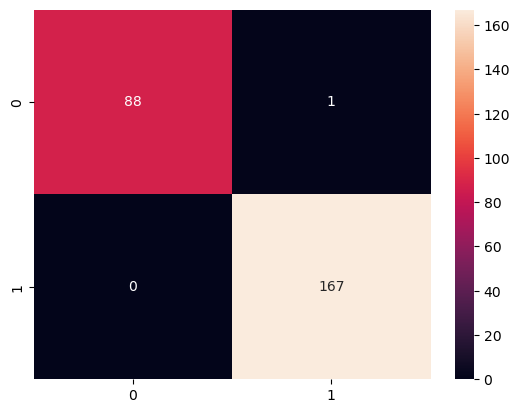

In [37]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt = 'd')

In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       0.99      1.00      1.00       167

    accuracy                           1.00       256
   macro avg       1.00      0.99      1.00       256
weighted avg       1.00      1.00      1.00       256

